# Example: Machine configuration

Here we will describe how to create the machine description files required to begin solving for Grad-Shafranov equilbiria in FreeGSNKE. 

A machine description in FreeGSNKE is comprised of:
- **active coils** (whose currents and voltages are used to control the plasma shape and position).
- **passive structures** (that make up the tokamak vessel, coil cans, support structures etc.)
- **limiter/wall** (that are non-conducting surfaces used to constrain the plasma boundary).
- **magnetic sensors** (such as pickup coils and fluxloops, whose readings can be measured at their locations around the tokamak after identifying an equilibrium).

In the following, we build up each of these elements into the structures required by FreeGSNKE and save them for later use.

## Import packages

In [1]:
import numpy as np
import pickle

## Active coils
First, we define the characteristics that make up the active coils in our tokamak. We begin by defining the **resistivity** of the material that the active coils are made of (in this case, copper coils). 

In [2]:
eta_copper = 1.55e-8  # resistivity in Ohm*m

Here we will specify five coils named: `Pz`, `P1_upper`, `P1_lower`, `P2_upper`, `P2_lower` and a central `Solenoid`. Each coil will contain a different number of individual windings (sometimes known as turns or filaments).

We've also made a shortcut and assumed that `P1_lower` and `P1_upper` have the same radial position and are equally distanced from the midplane in the vertical direction. The same applies to `P2_lower` and `P2_upper`.

We can now begin to populate a Python dictionary (here called `active_coils`) with our coils.

Each entry to the dictionary will be another dictionary describing either a **single** coil or **multiple** coils that are linked to the same power supply (i.e. will have the same **current**):
 - `Pz` will be a single standalone coil. 
 - `P1_upper` and `P1_lower` will form an up-down symmetric pair (as will `P2_upper` and `P2_lower`).

The keys for the coil dictionaries are:
- `R`: list of radial positions of windings.
- `Z`: list of vertical positions of windings.
- `dR`: width of each winding. 
- `dZ`: height of each winding. 
- `resistivity`: resistivity of coil material (in Ohm*m).
- `polarity`: circuit wiring, enabling coil pairs to be linked in series or anti-series (typically +1 or -1).
- `multiplier`: current multiplier, used for splitting current among coils (default = 1).

First, instatiate the dictionary that will contain all of the coils:

In [3]:
active_coils = {}

Let's  define the standalone `Pz` coil first.

In [4]:
active_coils["Pz"] = {}

active_coils["Pz"][""] = {
    "R": [1.75],
    "Z": [0.0],
    "dR": 0.25,
    "dZ": 0.25,
    "resistivity": eta_copper,
    "polarity": 1,
    "multiplier": 1,
}

Now let's define the `P1_upper` and `P1_lower` coils.

In [5]:
# The P1 coil group is instantiated as a dictionary
active_coils["P1"] = {}

# Populate with the P1_upper coil information
active_coils["P1"]["upper"] = {
    "R": [0.7, 0.7, 0.8, 0.8],       # coil has four windings
    "Z": [1.1, 1.2, 1.1, 1.2],
    "dR": 0.08,
    "dZ": 0.08,
    "resistivity": eta_copper,
    "polarity": 1,
    "multiplier": 1,
}

# Populate with the P1_lower coil information
active_coils["P1"]["lower"] = {
    "R": [0.7, 0.7, 0.8, 0.8],
    "Z": [-1*z for z in [1.1, 1.2, 1.1, 1.2]], # note the lower coil has opposite mirrored z-coords compared to upper
    "dR": 0.08,
    "dZ": 0.08,
    "resistivity": eta_copper,
    "polarity": 1,                             # note polarity is 1, so it will have same current as upper coil
    "multiplier": 1,
}

We follow the same procedure for `P2_upper` and `P2_lower`.

In [6]:
active_coils["P2"] = {}
active_coils["P2"]["upper"] = {
    "R": [1.7, 1.7, 1.8],     # coil has three windings
    "Z": [0.6, 0.7, 0.6],
    "dR": 0.06,
    "dZ": 0.06,
    "resistivity": eta_copper,
    "polarity": 1,
    "multiplier": 1
}
active_coils["P2"]["lower"] = {
    "R": [1.7, 1.7, 1.8],
    "Z": [-1*z for z in [0.6, 0.7, 0.6]],  # again, z-coords are mirrored
    "dR": 0.06,
    "dZ": 0.06,
    "resistivity": eta_copper,
    "polarity": -1,                        # negative polarity indicates current will have opposite sign to upper coil
    "multiplier": 1
}

Lastly, we can also define a Solenoid (that typically drives Ohmic current in the plasma). Current in the solenoid will have an impact on the equilibrium and needs to be accounted for in most cases. 

In [7]:
active_coils["Solenoid"] = {
    "R": [0.15]*16 + [0.2]*16,   # here we have 32 windings
    "Z": list(np.linspace(-0.6, 0.6, 16)) + list(np.linspace(-0.6, 0.6, 16)),
    "dR": 0.02,
    "dZ": 0.02,
    "polarity": 1,
    "resistivity": eta_copper,
    "multiplier": 1
}

Now we can save the active coils dictionary for later use by FreeGSNKE.

In [8]:
import os
if not os.path.exists("../machine_configs/example"):
    os.makedirs("../machine_configs/example")

with open("../machine_configs/example/active_coils.pickle", "wb") as f:
   pickle.dump(active_coils, f)

## Passive structures
Passive structures in FreeGSNKE are toroidally symmetric conducting structures that contain eddy currents induced by the active coils and the plasma. These non-voltage driven currents alter the magnetic field in the device and significantly affect equilibrium calculations. These can include support structures, the vessel, coil cans, etc.

FreeGSNKE supports two different kind of passive structures:
- filaments (i.e. single point sources)
- polygonal structures (i.e. multiple grouped filaments). 

The full description of passive structures is provided by the user as a list of dictionaries.

An element modelled as a single **filament** must include each of the following characteristics:
- `R`: centre in the radial coordinate. 
- `Z`: centre in the vertical coordinate.
- `dR`: width.
- `dZ`: height.
- `resistivity`: resistivity.
- `name`: name of the passive structure, optional.

These filaments are plotted as grey circles with a black outline in FreeGSNKE where their sizes are proportional to the height/width.

An element describing a **polygonal shape** must include:
- `R`: list or array of four radial coordinates for the polygon's vertices.
- `Z`: list or array of four vertical coordinates for the polygon's vertices.
- `resistivity`: resistivity.
- `name`: name of the passive structure, optional.
- `min_refine_per_area`: number of refinement points per m^2, optional.
- `min_refine_per_length`: number of refinement points per m, optional.

These filaments are plotted as polygons in FreeGSNKE with a black outline and grey interior.

Note 1: The polygonal-shaped passives are "refined" under the hood in FreeGSNKE and are typically modelled using a large number of individual filaments that uniformly distribute current assigned to the polygon (see [Pentland et al. (2024)](https://arxiv.org/abs/2407.12432) for a description of this process).

Note 2: Passives may also contain other information (recorded under their own keys - that won't affect calculations). 

In this example, we include both types. The list is named `passive_coils` to emphasise that the passive structures are modelled as coils under the hood. 

In [9]:
resistivity_wall = 5.5e-7   # resistivity of material (typically steel)

passive_coils = []

# some individual filaments
passive_coils.append({
    "R": 1.55,
    "Z": -1.1,
    "dR": 0.05,
    "dZ": 0.05,
    "resistivity": resistivity_wall
})

passive_coils.append({
    "R": 1.55,
    "Z": 1.1,
    "dR": 0.05,
    "dZ": 0.05,
    "resistivity": resistivity_wall
})

passive_coils.append({
    "R": 1.55,
    "Z": -1.2,
    "dR": 0.07,
    "dZ": 0.07,
    "resistivity": resistivity_wall
})

passive_coils.append({
    "R": 1.55,
    "Z": 1.2,
    "dR": 0.07,
    "dZ": 0.07,
    "resistivity": resistivity_wall
})




# some polygons to be refined
passive_coils.append({
    "R": [.25,2.1,2.1,.25],
    "Z": [-1.3,-1.35,-1.4,-1.35],
    "name": 'passive_lower_wall',
    "resistivity": resistivity_wall
})

passive_coils.append({
    "R": [.25,2.1,2.1,.25],
    "Z": [1.3,1.35,1.4,1.35],
    "name": 'passive_upper_wall',
    "resistivity": resistivity_wall
})

passive_coils.append({
    "R": [.25,.275,.275,.25],
    "Z": [-1.25,-1.25,1.25,1.25],
    "name": 'passive_left_wall',
    "resistivity": resistivity_wall
})

passive_coils.append({
    "R": [2,2.1,2.1,2],
    "Z": [-1.3,-1.3,1.3,1.3],
    "name": 'passive_right_wall',
    "resistivity": resistivity_wall
})

Save the passive structures to a pickle.

In [10]:
with open("../machine_configs/example/passive_coils.pickle", "wb") as f:
   pickle.dump(passive_coils, f)

## Limiter
A *limiter* in FreeGSNKE is a synthetic boundary that is used in various routines, typically it will be used to contain the core plasma. To define a limiter, simply specify points along its boundary.

For diverted plasmas, the limiter has no effect on the equilibrium or its evolution. For limiter plasmas, the last closed flux surface will be tangent to the limiter. FreeGSNKE will also force the last closed flux surface to lie entirely inside the region allowed by the limiter. In other words, outside the limiter, the constraint $J=0$ on the plasma current density is enforced. 

The format of the limiter coordinates for FreeGSNKE is a simple list of dictionaries with `R` and `Z` coordinates.

In [11]:
r_limiter = [1.3       , 1.27290862, 1.19457025, 1.07347408, 0.92274274,
       0.75871033, 0.59915229, 0.46135921, 0.36026312, 0.30681935,
       0.30681935, 0.36026312, 0.46135921, 0.59915229, 0.75871033,
       0.92274274, 1.07347408, 1.19457025, 1.27290862, 1.3]
z_limiter = [0.00000000e+00,  2.59759575e-01,  4.91370170e-01,  6.69733183e-01,
        7.75520213e-01,  7.97267594e-01,  7.32618661e-01,  5.88579129e-01,
        3.80757914e-01,  1.31675672e-01, -1.31675672e-01, -3.80757914e-01,
       -5.88579129e-01, -7.32618661e-01, -7.97267594e-01, -7.75520213e-01,
       -6.69733183e-01, -4.91370170e-01, -2.59759575e-01, -1.95943488e-16]

limiter = []
for r, z in zip(r_limiter, z_limiter):
    limiter.append({"R": r+0.05, "Z": z})

Save as a pickle file for FreeGSNKE to access later.

In [12]:
with open("../machine_configs/example/limiter.pickle", "wb") as f:
   pickle.dump(limiter, f)

## Wall
A *wall* in FreeGSNKE is very similar to a limiter. However, there is no $J=0$
constraint enforced outside the wall. The wall is used in plotting routines and
can be used to calculate useful quantities like divertor strike point locations.

In general, a wall and limiter in FreeGSNKE can be defined to be different
contours. For example, a tokamak with a divertor would have the wall following
the contour of the divertor, while the limiter might cut across the divertor
entrance.

In [13]:
r_wall = [0.3, 1.4, 1.4, 0.3, 0.3]
z_wall = [-0.85, -0.85, 0.85, 0.85, -0.85]


wall = []
for r, z in zip(r_wall, z_wall):
    wall.append({"R": r, "Z": z})

with open("../machine_configs/example/wall.pickle", "wb") as f:
   pickle.dump(wall, f)

## Magnetic Probes 

There are a variety of magnetic probes in the machine that measure various components of the magnetic field and or the flux function. The description of these is contained in a dictionary we'll call `magnetic_probes` which has the probe type as a key and then a list of smaller dictionaries for each individual probe. Currently the *flux loops* and *pickup coils* are implemented (others may be implemented at a later date).
- The **flux loops** compute the flux function $\psi(R,Z)$. The dictionary description contains the `name` and the `position` of the probe which is a 2D array with $R$ and $Z$ coordinates. 
- The **pickup coils** compute $B\cdot \hat n$ where $\hat n$ is a unit orientation vector of the probe. They are described by dictionaries containing the `name` as before, the `position` which is now a 3D array of coordinates $(R,\phi,Z)$, an `orientation` key with a string description of the orientation (parallel, toroidal, normal), and finally an `orientation_vector` $\hat n$. This is also a 3D array - it must be the same dimension as the position. 

For example, taking the first two probes of each type we would have the following dictionary structure.

In [14]:
# create list of flux loop dictionaries
flux_loops = []
flux_loops.append({'name': 'fl_nu_01', 'position': np.array([0.901 , 1.3582])})
flux_loops.append({'name': 'fl_nu_02', 'position':np.array([0.9544   , 1.3041999])})

# create list of pickup coil dictionaries
pickup_coils = []
pickup_coils.append({'name': 'b_c1_p01', 'position': np.array([2.76900e-01, 3.00000e+02, 1.26203e+00]), 'orientation': 'PARALLEL', 'orientation_vector': np.array([0., 0., 1.])}
)
pickup_coils.append({'name': 'b_c1_t02', 'position': np.array([2.7689108e-01, 2.9999680e+02, 1.2245095e+00]), 'orientation': 'TOROIDAL', 'orientation_vector': np.array([0., 1., 0.])}
)

# create magnetic probes dictionary
magnetic_probes = {'flux_loops': flux_loops, 'pickups': pickup_coils}

# save as pickle file
with open("../machine_configs/example/magnetic_probes.pickle", "wb") as f:
   pickle.dump(magnetic_probes, f)

## Building the machine
Now we'll plot the components of the machine to visualise its configuration.

In [15]:
import matplotlib.pyplot as plt

First, we set the paths to the pickle files we've just built. Then when we call 'build_machine.tokamak()', it will know which files to use. After this, we can plot the machine directly from the tokamak object (note that the limiter and wall need to be plot separately). 

In [16]:
# build machine
from freegsnke import build_machine
tokamak = build_machine.tokamak(
    active_coils_path=f"../machine_configs/example/active_coils.pickle",
    passive_coils_path=f"../machine_configs/example/passive_coils.pickle",
    limiter_path=f"../machine_configs/example/limiter.pickle",
    wall_path=f"../machine_configs/example/wall.pickle",
    magnetic_probe_path=f"../machine_configs/example/magnetic_probes.pickle",
)

Active coils --> built from pickle file.
Passive structures --> built from pickle file.
Limiter --> built from pickle file.
Wall --> built from pickle file.
Magnetic probes --> built from pickle file.
Resistance (R) and inductance (M) matrices --> built using actives (and passives if present).
Tokamak built.


Note that here the magnetic probes have not been plotted, this will be shown in a later notebook. 

Text(10.027777777777777, 0.5, 'Height, $Z$ [m]')

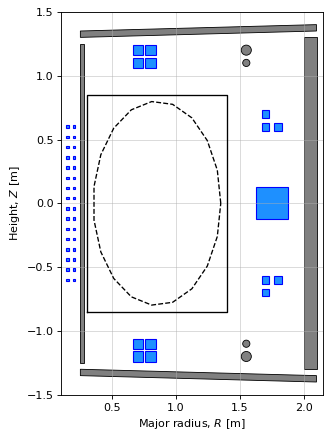

In [17]:
# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
plt.tight_layout()

tokamak.plot(axis=ax1, show=False)
ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")

ax1.grid(alpha=0.5)
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-1.5, 1.5)
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')

It is worth spending some time exploring the `tokamak` object to get familiar with all of the information it holds. A number of methods may not work properly yet as we have not instatiated an equilibrium object (that will be in a future notebook).  

We can, however, look at the active coils and other features defined in our tokamak.

In [18]:
tokamak.coils_list

['Pz',
 'P1',
 'P2',
 'Solenoid',
 'passive_0',
 'passive_1',
 'passive_2',
 'passive_3',
 'passive_lower_wall',
 'passive_upper_wall',
 'passive_left_wall',
 'passive_right_wall']

In [19]:
tokamak.coils_dict["P1"]

{'active': True,
 'coords': array([[ 0.7,  0.7,  0.8,  0.8,  0.7,  0.7,  0.8,  0.8],
        [ 1.1,  1.2,  1.1,  1.2, -1.1, -1.2, -1.1, -1.2]]),
 'polarity': array([1, 1, 1, 1, 1, 1, 1, 1]),
 'multiplier': array([1, 1, 1, 1, 1, 1, 1, 1]),
 'dR': 0.08,
 'dZ': 0.08,
 'resistivity_over_area': 2.421875e-06}

Notice how passive coils have the 'active': False property (distinguishing them from the actual active coils) and have a multiplier value less than 1 (in the polygon case). This is because the polygon has been refined under the hood using lots of individual filaments. If we were to assign a current to this passive structure, the multiplier says that each filament will be assigned this fraction of the total current. This helps spread the total current over the total surface area of the polygonal shape. 

In [20]:
tokamak.coils_dict["passive_lower_wall"] 

{'active': False,
 'vertices': array([[ 0.25,  2.1 ,  2.1 ,  0.25],
        [-1.3 , -1.35, -1.4 , -1.35]]),
 'coords': array([[ 1.58520293,  1.60128968,  1.61737643,  1.63346319,  1.64954994,
          1.66563669,  1.68172344,  1.6978102 ,  1.71389695,  1.7299837 ,
          1.74607045,  1.7621572 ,  1.77824396,  1.79433071,  1.81041746,
          1.82650421,  1.84259097,  1.85867772,  1.87476447,  1.89085122,
          1.90693797,  1.92302473,  1.93911148,  1.95519823,  1.97128498,
          1.98737173,  2.00345849,  2.01954524,  2.03563199,  2.05171874,
          2.0678055 ,  2.08389225,  2.099979  ,  1.05434011,  1.07042686,
          1.08651361,  1.10260037,  1.11868712,  1.13477387,  1.15086062,
          1.16694737,  1.18303413,  1.19912088,  1.21520763,  1.23129438,
          1.24738113,  1.26346789,  1.27955464,  1.29564139,  1.31172814,
          1.3278149 ,  1.34390165,  1.3599884 ,  1.37607515,  1.3921619 ,
          1.40824866,  1.42433541,  1.44042216,  1.45650891,  1.4725

In [21]:
tokamak.limiter

Wall(R=[1.35, 1.32290862, 1.24457025, 1.12347408, 0.97274274, 0.80871033, 0.6491522900000001, 0.5113592100000001, 0.41026312, 0.35681935, 0.35681935, 0.41026312, 0.5113592100000001, 0.6491522900000001, 0.80871033, 0.97274274, 1.12347408, 1.24457025, 1.32290862, 1.35], Z=[0.0, 0.259759575, 0.49137017, 0.669733183, 0.775520213, 0.797267594, 0.732618661, 0.588579129, 0.380757914, 0.131675672, -0.131675672, -0.380757914, -0.588579129, -0.732618661, -0.797267594, -0.775520213, -0.669733183, -0.49137017, -0.259759575, -1.95943488e-16])

In [22]:
tokamak.wall

Wall(R=[0.3, 1.4, 1.4, 0.3, 0.3], Z=[-0.85, -0.85, 0.85, 0.85, -0.85])

We can view the currents assigned to each active coil and passive structure (noting that we have yet to assign or calculate any currents yet):

In [23]:
tokamak.getCurrents()

{'Pz': 0.0,
 'P1': 0.0,
 'P2': 0.0,
 'Solenoid': 0.0,
 'passive_0': 0.0,
 'passive_1': 0.0,
 'passive_2': 0.0,
 'passive_3': 0.0,
 'passive_lower_wall': 0,
 'passive_upper_wall': 0,
 'passive_left_wall': 0,
 'passive_right_wall': 0}

Using the following command, we can print all of the coil/passive information. Note that the 'mirror' field is not used and the 'control' field tells the inverse solver (in later notebooks) whether it should find a current for the coil (True) or not (False). We will see how this works when carrying out an inverse solve.

In [24]:
tokamak.printCurrents()

Pz : Circuit([("Pz", MultiCoil(R=[1.75], Z=[0.0], current=0.0, turns=1, control=True, mirror=False, polarity=[1.0, 1.0]), 1.0)], current=0.0, control=True)
P1 : Circuit([("P1upper", MultiCoil(R=[0.7, 0.7, 0.8, 0.8], Z=[1.1, 1.2, 1.1, 1.2], current=0.0, turns=4, control=True, mirror=False, polarity=[1.0, 1.0]), 1.0), ("P1lower", MultiCoil(R=[0.7, 0.7, 0.8, 0.8], Z=[-1.1, -1.2, -1.1, -1.2], current=0.0, turns=4, control=True, mirror=False, polarity=[1.0, 1.0]), 1.0)], current=0.0, control=True)
P2 : Circuit([("P2upper", MultiCoil(R=[1.7, 1.7, 1.8], Z=[0.6, 0.7, 0.6], current=0.0, turns=3, control=True, mirror=False, polarity=[1.0, 1.0]), 1.0), ("P2lower", MultiCoil(R=[1.7, 1.7, 1.8], Z=[-0.6, -0.7, -0.6], current=0.0, turns=3, control=True, mirror=False, polarity=[1.0, 1.0]), -1.0)], current=0.0, control=True)
Solenoid : Circuit([("Solenoid", MultiCoil(R=[0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2

## Building the machine (alternate)
One can alternatively build the machine by providing data directly, instead of providing paths to pickle files. 

This can be useful if one needs to build multiple tokamaks in a session (for optimisation purposes or otherwise). 

In [25]:
# build machine
from freegsnke import build_machine
tokamak_alt = build_machine.tokamak(
    active_coils_data=active_coils,
    passive_coils_data=passive_coils,
    limiter_data=limiter,
    wall_data=wall,
    magnetic_probe_data=magnetic_probes,
)

Active coils --> built from user-provided data.
Passive structures --> built from user-provided data.
Limiter --> built from user-provided data.
Wall --> built from user-provided data.
Magnetic probes --> built from user-provided data.
Resistance (R) and inductance (M) matrices --> built using actives (and passives if present).
Tokamak built.


Text(10.027777777777777, 0.5, 'Height, $Z$ [m]')

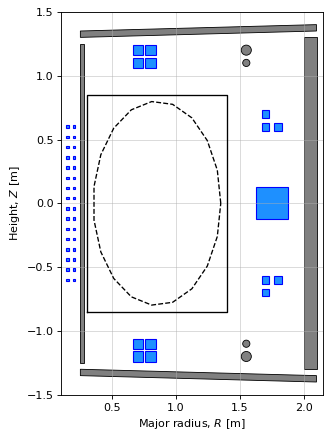

In [26]:
# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
plt.tight_layout()

tokamak_alt.plot(axis=ax1, show=False)
ax1.plot(tokamak_alt.limiter.R, tokamak_alt.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak_alt.wall.R, tokamak_alt.wall.Z, color='k', linewidth=1.2, linestyle="-")

ax1.grid(alpha=0.5)
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-1.5, 1.5)
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')